In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
from loguru import logger
logger.remove()

from pim.simulator import SimulationExperiment
from pim.cx import fit_cpu4, to_cartesian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


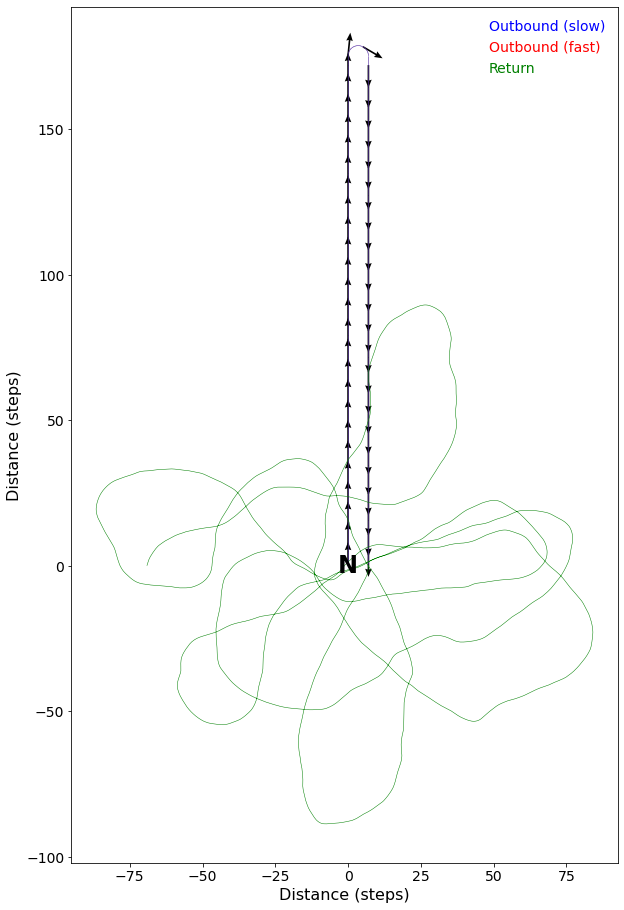

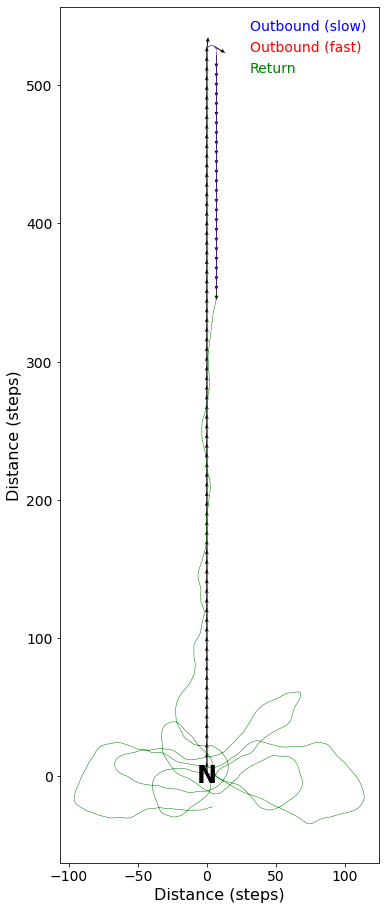

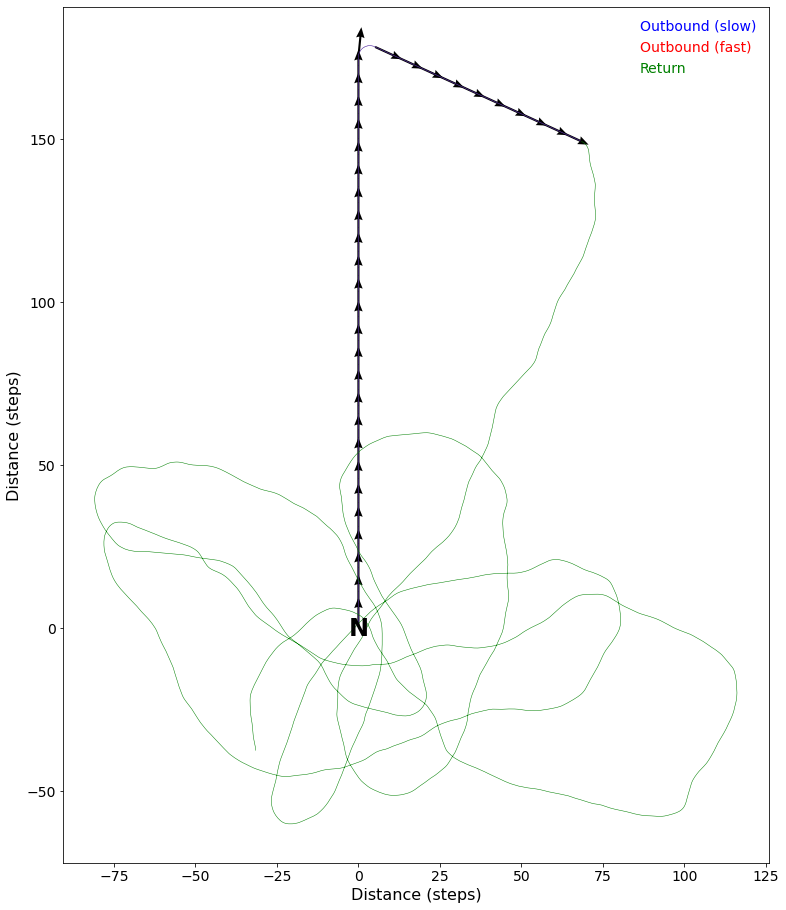

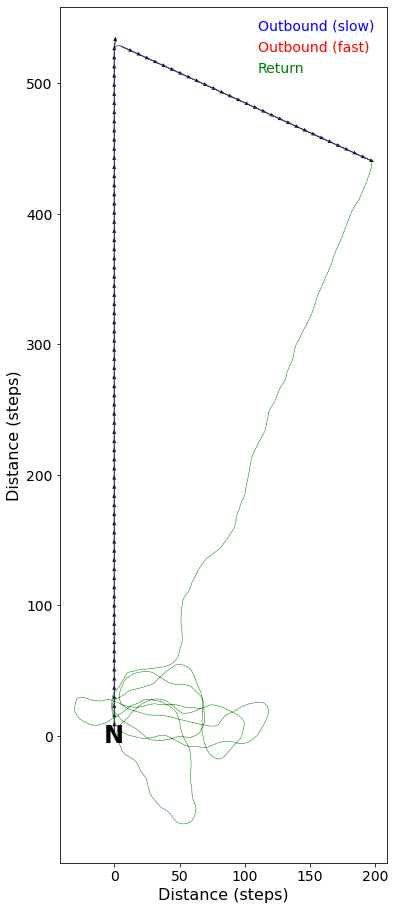

In [56]:
# We want to explore the consequences of non-linear integration on homing performance.
# In particular, there are two properties we want:
# * Movements of the same distance in opposite directions should cancel out, and
# * Movements of the same angular distance should change the phase equally, regardless of distance from home

def turn(f, t, per):
    headings = np.arange(f, t, per)
    return np.vstack([np.ones(len(headings)), headings]).T

# To test the first property, let's just move in one direction and then back:
path1p1 = np.vstack([
    [[500, 0]],
    turn(0, np.pi, 0.1),
    [[500, np.pi]]
])

path2p1 = np.vstack([
    [[1500, 0]],
    turn(0, np.pi, 0.1),
    [[500, np.pi]]
])

path1p2 = np.vstack([
    [[500, 0]],
    turn(0, 2, 0.1),
    [[200, 2]],
])

path2p2 = np.vstack([
    [[1500, 0]],
    turn(0, 2, 0.1),
    [[600, 2]],
])

# To test the second property, let's move in one direction for r units, and then turn



for path in [path1p1, path2p1, path1p2, path2p2]:
    parameters = {
        "type": "simulation",
        "seed": 42,
        "T_inbound": 3000,
        "path": path,
        "min_homing_distance": 300,
        "motor_factor": -0.5,
        "record": ["memory", "TB1", "Pontine", "motor", "theory", "CPU4", "CPU4.old"],
        "cx": {
            "type": "weights",
            "output_layer": "motor",
            "params": {
                "noise": 0.1,
                "motor_noise": 0.1,
                "mem_initial": 0.5,
                "mem_fade": 0.15 + 0.5,
                "mem_gain": 0.0023,
                #"cpu1_slope": 1000,#00,
                #"cpu1_bias": 2,#5,
                "pfn_background_activity": 0.5,
            }
        }
    }

    experiment = SimulationExperiment(parameters)
    results = experiment.run("test")

    results.report()